In [21]:
import shutil
from pathlib import Path
import random

# === Einstellungen ===
ROOT = Path(r"C:\Users\smart.farming\Desktop\TomBA\Bilddaten\Weizen_Oberholz")
SRC_TRAIN = ROOT / "train"           # Quellordner mit Klassen
DEST_ROOT = ROOT / "ceal_split"      # Zielordner
INITIAL_FRAC = 0.20                  # Anteil der initialen Daten
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
SEED = 42

# === Funktionen ===
def find_classes(src_train: Path):
    return sorted([d.name for d in src_train.iterdir() if d.is_dir()])

def collect_images(folder: Path, img_exts):
    return [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in img_exts]

def ensure_dirs(dest_root: Path, class_names):
    for split in ["initial_data", "unlabeled_pool"]:
        for cls in class_names:
            (dest_root / split / cls).mkdir(parents=True, exist_ok=True)

def split_and_copy(src_train, dest_root, class_names, initial_frac, seed, img_exts):
    rng = random.Random(seed)
    summary = []
    for cls in class_names:
        src_cls_dir = src_train / cls
        files = collect_images(src_cls_dir, img_exts)
        rng.shuffle(files)
        k_initial = max(1, int(round(len(files) * initial_frac))) if len(files) > 1 else 1
        initial_files = files[:k_initial]
        pool_files = files[k_initial:]

        for p in initial_files:
            dst = dest_root / "initial_data" / cls / p.name
            shutil.copy2(p, dst)
        for p in pool_files:
            dst = dest_root / "unlabeled_pool" / cls / p.name
            shutil.copy2(p, dst)

        summary.append({
            "class": cls,
            "total": len(files),
            "initial": len(initial_files),
            "pool": len(pool_files),
        })
    return summary

# === Hauptprogramm ===
def main():
    if not SRC_TRAIN.exists():
        print(f"❌ Quellordner nicht gefunden: {SRC_TRAIN}")
        return

    class_names = find_classes(SRC_TRAIN)
    if not class_names:
        print("❌ Keine Klassen gefunden.")
        return

    # Zielordner neu erzeugen → alte Inhalte löschen
    if DEST_ROOT.exists():
        shutil.rmtree(DEST_ROOT)
    DEST_ROOT.mkdir(parents=True, exist_ok=True)

    ensure_dirs(DEST_ROOT, class_names)
    summary = split_and_copy(SRC_TRAIN, DEST_ROOT, class_names, INITIAL_FRAC, SEED, IMG_EXTS)

    # Zusammenfassung ausgeben
    print("\n✅ Split abgeschlossen!")
    total_all = sum(s["total"] for s in summary)
    init_all = sum(s["initial"] for s in summary)
    pool_all = sum(s["pool"] for s in summary)

    for s in summary:
        print(f"  {s['class']}: total={s['total']}, initial={s['initial']}, pool={s['pool']}")
    print(f"— Summe: total={total_all}, initial={init_all}, pool={pool_all}")
    print(f"→ Zielstruktur: {DEST_ROOT.resolve()}")

if __name__ == "__main__":
    main()



✅ Split abgeschlossen!
  BBCH 30: total=1694, initial=339, pool=1355
  BBCH 31: total=1638, initial=328, pool=1310
  BBCH 32-34: total=1819, initial=364, pool=1455
  BBCH 37: total=1796, initial=359, pool=1437
  BBCH 39: total=1819, initial=364, pool=1455
— Summe: total=8766, initial=1754, pool=7012
→ Zielstruktur: C:\Users\smart.farming\Desktop\TomBA\Bilddaten\Weizen_Oberholz\ceal_split


In [22]:
# =========================================
# CEAL (Optimiert)
# =========================================
from pathlib import Path
import os, shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns                     # === NEU ===
from sklearn.metrics import classification_report, confusion_matrix   # === NEU ===
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler,  ModelCheckpoint, TensorBoard
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import backend as K


# --------------------------
# Parameter / Pfade
# --------------------------
DATA_ROOT = Path(r"C:\Users\smart.farming\Desktop\TomBA\Bilddaten\Weizen_Oberholz")
DATA_ROOT2 = DATA_ROOT / "ceal_split"
INIT_DIR  = DATA_ROOT2 / "initial_data"
POOL_DIR  = DATA_ROOT2 / "unlabeled_pool"

DATA_BASE = DATA_ROOT     
VAL_DIR   = DATA_BASE / "val"      # optional
TEST_DIR  = DATA_BASE / "test"     # muss vorhanden sein

CLASS_NAMES = ["BBCH 30","BBCH 31","BBCH 32-34","BBCH 37","BBCH 39"]
class_names = CLASS_NAMES

TARGET_SIZE = (224, 224)
BATCH_SIZE  = 32
SEED        = 42

WARMUP_EPOCHS = 10

# CEAL-Parameter
ROUNDS            = 22
EPOCHS_PER_ROUND  = 2
K_UNCERTAIN       = 200
DELTA0            = 0.05
DELTA_DECAY       = 0.0033
UNCERT_CRITERION  = "entropy"

np.random.seed(SEED)
tf.random.set_seed(SEED)

# --------------------------
# Preprocessing & Augmentation
# --------------------------
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def custom_augmentation(img):
    img = tf.image.random_contrast(img, lower=0.95, upper=1.05)
    img = tf.image.random_hue(img, max_delta=0.05)
    return img

train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: custom_augmentation(preprocess_input(x)),
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.9, 1.1],
    channel_shift_range=10.0,
    fill_mode='reflect',
    featurewise_center=False,
    featurewise_std_normalization=False
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# --------------------------
# MobileNetV2 bauen
# --------------------------
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

def build_mobilenetv2(num_classes: int, input_size=(224,224,3), weights="imagenet", base_trainable=False, lr=1e-4):
    base = tf.keras.applications.MobileNetV2(
        input_shape=input_size, include_top=False, weights=weights
    )
    base.trainable = base_trainable

    inputs = tf.keras.Input(shape=input_size)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    # Erste Dense-Schicht
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    # Zweite Dense-Schicht für bessere Feature-Separation
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    # Speichere die Referenz auf den Basis-Teil === NEU ===
    model.base = base

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Initiales Modell
model = build_mobilenetv2(num_classes=len(class_names), input_size=(*TARGET_SIZE,3), weights="imagenet", base_trainable=False, lr=1e-4)


In [24]:
# --------------------------
# Unsicherheitsmetriken
# --------------------------
def softmax_entropy(probs: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    return -np.sum(probs * np.log(np.clip(probs, eps, 1.0)), axis=1)

def least_confidence(probs: np.ndarray) -> np.ndarray:
    return 1.0 - np.max(probs, axis=1)

def margin_sampling(probs: np.ndarray) -> np.ndarray:
    part = -np.sort(-probs, axis=1)
    return part[:,0] - part[:,1]

def score_uncertainty(probs: np.ndarray, criterion: str = "entropy") -> np.ndarray:
    if criterion == "entropy":
        return softmax_entropy(probs)
    elif criterion == "least_confidence":
        return least_confidence(probs)
    elif criterion == "margin":
        return -margin_sampling(probs)
    else:
        raise ValueError("criterion muss 'entropy', 'least_confidence' oder 'margin' sein.")

In [25]:
# --------------------------
# Erweiterte Evaluation
# --------------------------
def eval_detailed(model, test_dir):
    df_t = df_from_dir(test_dir, class_names)
    it = flow_for_training(df_t, val_datagen, TARGET_SIZE, BATCH_SIZE, class_names, shuffle=False, seed=SEED)
    y_true = it.classes
    y_pred = np.argmax(model.predict(it), axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [26]:
# --------------------------
# Sanity-Checks
# --------------------------
IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp",".JPG",".PNG",".JPEG")

def count_images(dir_path: Path, classes, exts=IMG_EXTS):
    total = 0
    per_class = {}
    if not dir_path.exists():
        print(f"❌ fehlt: {dir_path}")
        return 0, {}
    for c in classes:
        d = dir_path / c
        n = 0
        if d.exists():
            for p in d.rglob("*"):
                if p.is_file() and p.suffix in exts:
                    n += 1
        per_class[c] = n
        total += n
    print(f"{dir_path} -> total={total} | " + ", ".join(f"{k}:{v}" for k,v in per_class.items()))
    return total, per_class

_ = count_images(INIT_DIR, class_names)
_ = count_images(POOL_DIR, class_names)
_ = count_images(VAL_DIR,  class_names)
_ = count_images(TEST_DIR, class_names)

C:\Users\smart.farming\Desktop\TomBA\Bilddaten\Weizen_Oberholz\ceal_split\initial_data -> total=1754 | BBCH 30:339, BBCH 31:328, BBCH 32-34:364, BBCH 37:359, BBCH 39:364
C:\Users\smart.farming\Desktop\TomBA\Bilddaten\Weizen_Oberholz\ceal_split\unlabeled_pool -> total=7012 | BBCH 30:1355, BBCH 31:1310, BBCH 32-34:1455, BBCH 37:1437, BBCH 39:1455
C:\Users\smart.farming\Desktop\TomBA\Bilddaten\Weizen_Oberholz\val -> total=1882 | BBCH 30:363, BBCH 31:351, BBCH 32-34:391, BBCH 37:386, BBCH 39:391
C:\Users\smart.farming\Desktop\TomBA\Bilddaten\Weizen_Oberholz\test -> total=1879 | BBCH 30:363, BBCH 31:351, BBCH 32-34:390, BBCH 37:385, BBCH 39:390


In [27]:
# --------------------------
# Hilfsfunktionen
# --------------------------
def df_from_dir(root: Path, class_names):
    rows = []
    if not root.exists():
        return pd.DataFrame(rows)
    for c in class_names:
        d = root / c
        if not d.exists():
            continue
        for p in d.rglob("*"):
            if p.is_file() and p.suffix in IMG_EXTS:
                rows.append({"filepath": str(p), "class_name": c})
    return pd.DataFrame(rows)

def flow_for_prediction(df, datagen, target_size, batch_size, shuffle, seed):
    if df is None or df.empty:
        return None
    dff = df.rename(columns={"filepath":"filename"}).copy()
    it = datagen.flow_from_dataframe(
        dff,
        x_col="filename",
        y_col=None,
        target_size=target_size,
        class_mode=None,
        shuffle=shuffle,
        batch_size=batch_size,
        seed=seed,
        validate_filenames=True
    )
    return it

def flow_for_training(df, datagen, target_size, batch_size, class_names, shuffle, seed):
    if df is None or df.empty:
        return None
    dff = df.rename(columns={"filepath":"filename","class_name":"class"}).copy()
    it = datagen.flow_from_dataframe(
        dff,
        x_col="filename",
        y_col="class",
        target_size=target_size,
        classes=class_names,
        class_mode="categorical",
        shuffle=shuffle,
        batch_size=batch_size,
        seed=seed,
        validate_filenames=True
    )
    return it

def eval_on_test(model, test_dir: Path) -> float:
    df_t = df_from_dir(test_dir, class_names)
    it = flow_for_training(df_t, val_datagen, TARGET_SIZE, BATCH_SIZE, class_names, shuffle=False, seed=SEED)
    if it is None or it.samples == 0:
        raise ValueError(f"Test-Set leer oder nicht gefunden unter {test_dir}")
    _, acc = model.evaluate(it, verbose=0)
    return float(acc)



=== Warm-up Training auf C:\Users\smart.farming\Desktop\TomBA\Bilddaten\Weizen_Oberholz\ceal_split\initial_data für 10 Epochen ===
Found 1754 validated image filenames belonging to 5 classes.
Found 1882 validated image filenames belonging to 5 classes.


c:\Users\smart.farming\Desktop\TomBA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.3877 - loss: 2.6521 - val_accuracy: 0.4798 - val_loss: 2.3452
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4487 - loss: 2.3563 - val_accuracy: 0.4814 - val_loss: 2.2286
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5023 - loss: 2.1839 - val_accuracy: 0.5271 - val_loss: 2.0484
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.4954 - loss: 2.1025 - val_accuracy: 0.5207 - val_loss: 2.0139
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5268 - loss: 1.9578 - val_accuracy: 0.5675 - val_loss: 1.8296
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5502 - loss: 1.8712 - val_accuracy: 0.5632 - val_loss: 1.7743
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5308 - loss: 1.8493 - val_accuracy: 0.5696 - val_loss: 1.7365
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5473 - loss: 1.7685 - val_accuracy: 0.5638 - val_loss

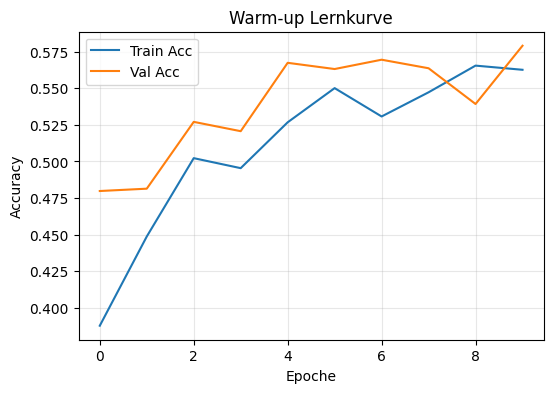

In [28]:
# --------------------------
# Erweiterter Warm-up
# --------------------------

if INIT_DIR.exists():
    print(f"\n=== Warm-up Training auf {INIT_DIR} für {WARMUP_EPOCHS} Epochen ===")
    df_init0 = df_from_dir(INIT_DIR, class_names)
    init_it = flow_for_training(df_init0, train_datagen, TARGET_SIZE, BATCH_SIZE, class_names, shuffle=True, seed=SEED)
    if init_it is not None and init_it.samples > 0:
        val_it = None
    if VAL_DIR.exists():
        df_val0 = df_from_dir(VAL_DIR, class_names)
        val_it = flow_for_training(df_val0, val_datagen, TARGET_SIZE, BATCH_SIZE, class_names, shuffle=False, seed=SEED)


history = model.fit(
    init_it,
    validation_data=val_it,
    epochs=WARMUP_EPOCHS,
    verbose=1
)


# Optional: Plot der Warm-up-Lernkurve
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
if val_it:
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Warm-up Lernkurve")
    plt.xlabel("Epoche")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [29]:
# --------------------------
# CEAL: eine Iteration
# --------------------------
def ceal_iteration(
    model,
    init_dir: Path,
    pool_dir: Path,
    k_uncertain: int,
    delta: float,
    criterion: str,
    epochs: int,
    val_dir: Path | None = None,
    callbacks: list = None
):
    df_pool = df_from_dir(pool_dir, class_names)
    if df_pool.empty:
        return {"empty_pool": True, "n_uncertain": 0, "n_highconf": 0}

    pool_pred_it = flow_for_prediction(df_pool, val_datagen, TARGET_SIZE, BATCH_SIZE, shuffle=False, seed=SEED)
    if pool_pred_it is None or pool_pred_it.samples == 0:
        return {"empty_pool": True, "n_uncertain": 0, "n_highconf": 0}

    probs = model.predict(pool_pred_it, verbose=0)
    scores = score_uncertainty(probs, criterion=criterion)

    # Unsichere Beispiele
    k = min(k_uncertain, len(df_pool))
    idx_unsure = np.argsort(-scores)[:k]
    df_unsure = df_pool.iloc[idx_unsure]

    # Pseudo-Labels
    ent = softmax_entropy(probs)
    idx_highconf = np.where(ent < delta)[0]
    df_highconf = df_pool.iloc[idx_highconf]
    pseudo_y = probs[idx_highconf].argmax(1) if len(idx_highconf) else np.array([], dtype=np.int32)
    idx2cls = {i:c for i,c in enumerate(class_names)}

    # Analyse der Pseudo-Label-Confidence
    if len(idx_highconf) > 0:
        confs = probs[idx_highconf].max(axis=1)
        plt.figure(figsize=(6,4))
        plt.hist(confs, bins=20, alpha=0.7, color="steelblue")
        plt.title("Pseudo-Label Confidence")
        plt.xlabel("Confidence")
        plt.ylabel("Anzahl")
        plt.show()

    # Unsichere -> verschieben
    for _, row in df_unsure.iterrows():
        p = Path(row["filepath"])
        true_cls = row["class_name"]
        dst = init_dir / true_cls / p.name
        dst.parent.mkdir(parents=True, exist_ok=True)
        if not dst.exists() and p.exists():
            shutil.move(str(p), str(dst))

    # Trainingsmenge der Runde
    df_init = df_from_dir(init_dir, class_names)
    df_train_round = df_init.copy()
    if len(df_highconf):
        df_pseudo = df_highconf.copy()
        df_pseudo["class_name"] = [idx2cls[i] for i in pseudo_y]
        df_train_round = pd.concat([df_train_round, df_pseudo], ignore_index=True)

    train_it = flow_for_training(df_train_round, train_datagen, TARGET_SIZE, BATCH_SIZE, class_names, shuffle=True, seed=SEED)
    val_it = None
    if val_dir is not None and Path(val_dir).exists():
        df_val = df_from_dir(Path(val_dir), class_names)
        val_it = flow_for_training(df_val, val_datagen, TARGET_SIZE, BATCH_SIZE, class_names, shuffle=False, seed=SEED)

    model.fit(train_it, validation_data=val_it, epochs=epochs, verbose=1,  callbacks=callbacks if callbacks else [])

    return {
        "empty_pool": False,
        "n_uncertain": int(len(df_unsure)),
        "n_highconf": int(len(df_highconf)),
        "idx_highconf": idx_highconf,  
        "pseudo_y": pseudo_y,
        "probs": probs,
        "pseudo_files": df_pool.iloc[idx_highconf]["filepath"].values,    
        "pseudo_true_labels": df_pool.iloc[idx_highconf]["class_name"].values
    }



=== CEAL Runde 1/22 | δ=0.0500 ===
Found 7012 validated image filenames.


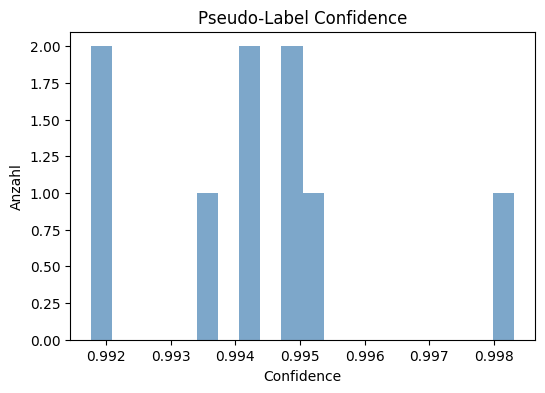

Found 1963 validated image filenames belonging to 5 classes.
Found 1882 validated image filenames belonging to 5 classes.


c:\Users\smart.farming\Desktop\TomBA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5537 - loss: 1.6501 - val_accuracy: 0.5717 - val_loss: 1.5605
Epoch 2/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.5736 - loss: 1.6007 - val_accuracy: 0.5606 - val_loss: 1.5898
Found 1879 validated image filenames belonging to 5 classes.


c:\Users\smart.farming\Desktop\TomBA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


→ Test-Accuracy nach Runde 1: 0.5668
Found 1879 validated image filenames belonging to 5 classes.


c:\Users\smart.farming\Desktop\TomBA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step
              precision    recall  f1-score   support

     BBCH 30       0.55      0.90      0.68       363
     BBCH 31       0.50      0.42      0.45       351
  BBCH 32-34       0.56      0.45      0.50       390
     BBCH 37       0.61      0.40      0.48       385
     BBCH 39       0.62      0.68      0.65       390

    accuracy                           0.57      1879
   macro avg       0.57      0.57      0.55      1879
weighted avg       0.57      0.57      0.55      1879



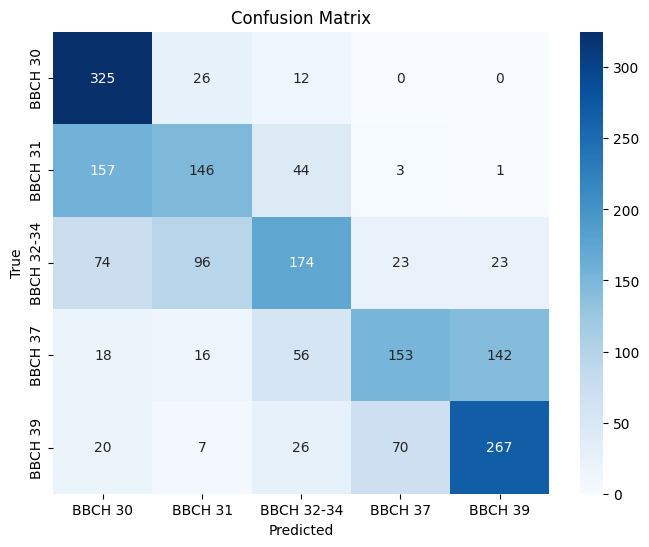

Pseudo-Labels für Runde 1 gespeichert.

Pseudo-Label Accuracy pro Klasse (%):


True_Label
BBCH 30     80.0
BBCH 31    100.0
BBCH 39    100.0
Name: Correct, dtype: float64

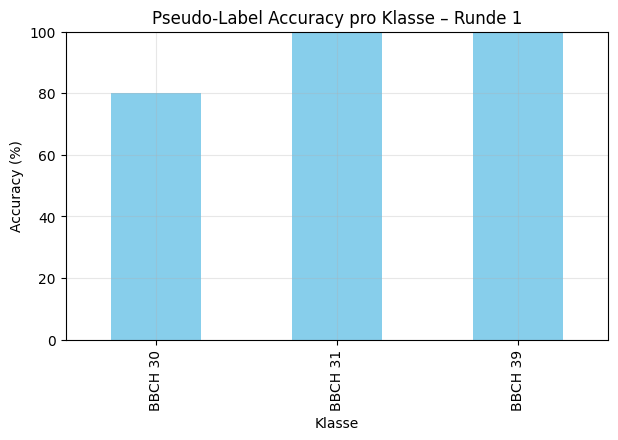


=== CEAL Runde 2/22 | δ=0.0467 ===
Found 6812 validated image filenames.


c:\Users\smart.farming\Desktop\TomBA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


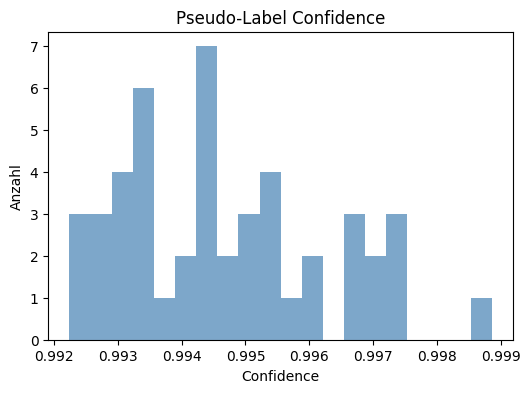

Found 2201 validated image filenames belonging to 5 classes.
Found 1882 validated image filenames belonging to 5 classes.


c:\Users\smart.farming\Desktop\TomBA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.5729 - loss: 1.5755 - val_accuracy: 0.5770 - val_loss: 1.5071
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.5516 - loss: 1.5637 - val_accuracy: 0.5606 - val_loss: 1.5653
Found 1879 validated image filenames belonging to 5 classes.


c:\Users\smart.farming\Desktop\TomBA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


→ Test-Accuracy nach Runde 2: 0.5498
Found 1879 validated image filenames belonging to 5 classes.


c:\Users\smart.farming\Desktop\TomBA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step
              precision    recall  f1-score   support

     BBCH 30       0.78      0.75      0.77       363
     BBCH 31       0.66      0.24      0.35       351
  BBCH 32-34       0.46      0.58      0.51       390
     BBCH 37       0.42      0.61      0.50       385
     BBCH 39       0.60      0.56      0.58       390

    accuracy                           0.55      1879
   macro avg       0.59      0.55      0.54      1879
weighted avg       0.58      0.55      0.54      1879



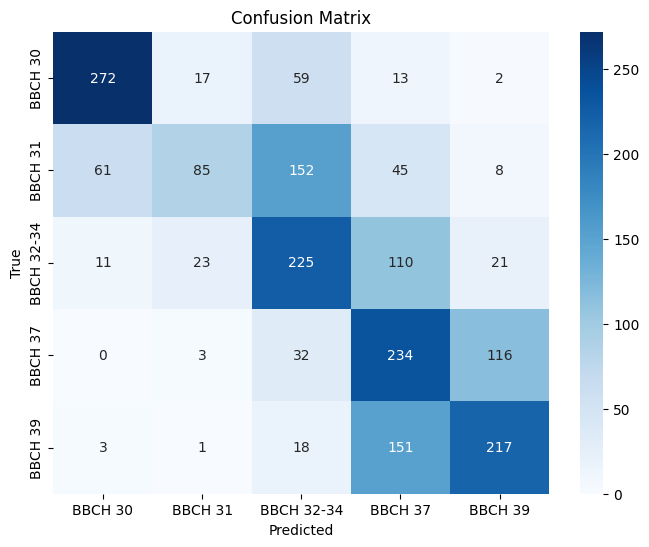

Pseudo-Labels für Runde 2 gespeichert.

Pseudo-Label Accuracy pro Klasse (%):


True_Label
BBCH 30    100.0
BBCH 39    100.0
Name: Correct, dtype: float64

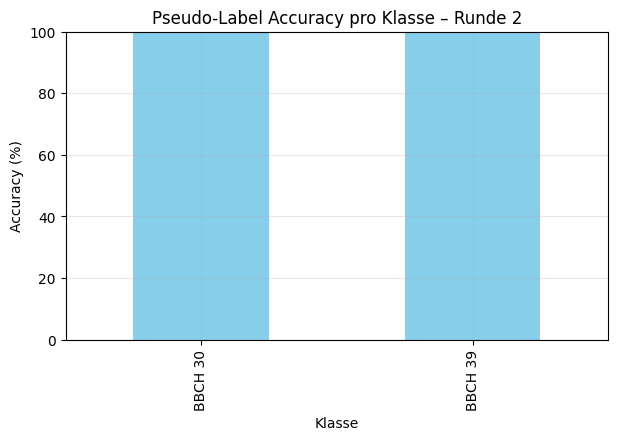


=== CEAL Runde 3/22 | δ=0.0434 ===
Found 6612 validated image filenames.


c:\Users\smart.farming\Desktop\TomBA\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [30]:
# --------------------------
# MAIN-LOOP
# --------------------------
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping Callback für CEAL-Runden
#early_stopping_ceal = EarlyStopping(
#    monitor="val_loss",
#   patience=2,
#    restore_best_weights=True,
#    verbose=1
#)

delta = float(DELTA0)
log_rows = []

for r in range(1, ROUNDS + 1):
    print(f"\n=== CEAL Runde {r}/{ROUNDS} | δ={delta:.4f} ===")

    # CEAL-Iteration
    out = ceal_iteration(
        model=model,
        init_dir=INIT_DIR,
        pool_dir=POOL_DIR,
        k_uncertain=K_UNCERTAIN,
        delta=delta,
        criterion=UNCERT_CRITERION,
        epochs=EPOCHS_PER_ROUND,
        val_dir=VAL_DIR if VAL_DIR.exists() else None,
        #callbacks=[early_stopping_ceal]  # Early Stopping
    )

    if out.get("empty_pool", False):
        print("→ Pool leer – CEAL beendet.")
        break

    # Test-Accuracy + detaillierte Evaluation
    acc = eval_on_test(model, TEST_DIR)
    print(f"→ Test-Accuracy nach Runde {r}: {acc:.4f}")
    eval_detailed(model, TEST_DIR)

    # Pseudo-Label Analyse
    df_pool = df_from_dir(POOL_DIR, class_names)
    if len(df_pool) > 0 and out["n_highconf"] > 0:
        # idx_highconf und pseudo_y müssen aus ceal_iteration zurückgegeben oder global verfügbar sein
        idx_highconf = out.get("idx_highconf", [])
        pseudo_y = out.get("pseudo_y", [])
        probs = out.get("probs", None)

        if len(idx_highconf) > 0:
            idx2cls = {i: c for i, c in enumerate(class_names)}
            pseudo_df = pd.DataFrame({
                "Datei": out["pseudo_files"],
                "True_Label": out["pseudo_true_labels"],
                "Pseudo_Label": [idx2cls[i] for i in pseudo_y],
                "Confidence": probs[idx_highconf].max(axis=1)
            })
            pseudo_df["Correct"] = pseudo_df["True_Label"] == pseudo_df["Pseudo_Label"]

            # CSV speichern
            pseudo_df.to_csv(f"pseudo_labels_runde_{r}.csv", index=False)
            print(f"Pseudo-Labels für Runde {r} gespeichert.")

            # Genauigkeit pro Klasse
            class_acc = pseudo_df.groupby("True_Label")["Correct"].mean() * 100
            class_acc = class_acc.round(2)
            print("\nPseudo-Label Accuracy pro Klasse (%):")
            display(class_acc)

            # Balkendiagramm
            class_acc.plot(kind="bar", color="skyblue", figsize=(7,4))
            plt.title(f"Pseudo-Label Accuracy pro Klasse – Runde {r}")
            plt.ylabel("Accuracy (%)")
            plt.xlabel("Klasse")
            plt.ylim(0, 100)
            plt.grid(alpha=0.3)
            plt.show()

    # Unfreeze ab Runde 4
    if r == 4:
        print("\n=== Unfreezing der letzten 20 MobileNetV2-Layer ===")
        model.base.trainable = True
        for layer in model.base.layers[:-20]:
            layer.trainable = False

    # δ senken
    delta = max(0.0, delta - DELTA_DECAY)

    # Logging
    log_rows.append({
        "round": r,
        "n_uncertain": out["n_uncertain"],
        "n_highconf": out["n_highconf"],
        "delta": float(delta),
        "test_acc": float(acc)
    })


,round,n_uncertain,n_highconf,delta,test_acc
0,1,200,121,0.0467,0.538333
1,2,200,222,0.0434,0.527222
2,3,200,115,0.0401,0.541111
3,4,200,175,0.0368,0.527222
4,5,200,181,0.0335,0.522222
5,6,200,73,0.0302,0.583889
6,7,200,111,0.0269,0.496111
7,8,200,168,0.0236,0.541111
8,9,200,5,0.0203,0.530000
9,10,200,0,0.0170,0.538889


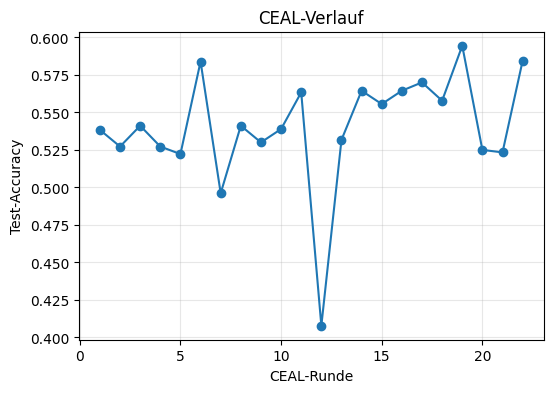

In [ ]:
# --------------------------
# Ergebnisse / Plot
# --------------------------
ceal_log = pd.DataFrame(log_rows)
display(ceal_log)

plt.figure(figsize=(6,4))
plt.plot(ceal_log["round"], ceal_log["test_acc"], marker="o")
plt.xlabel("CEAL-Runde")
plt.ylabel("Test-Accuracy")
plt.title("CEAL-Verlauf")
plt.grid(True, alpha=0.3)
plt.show()
